In [1]:
import numpy as np
import seaborn as sns
import sklearn.gaussian_process as gp
import warnings
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.datasets import make_classification
from numpy.random import RandomState

from util.defs import ParamType
from acquisition.acquisition_functions import ProbabilityOfImprovement, ExpectedImprovement
from acquisition.acquisition_optimizers import RandomAcquisitionOpt, ConstrainedAcquisitionOpt
from hp_optimizers.hp_optimizer import GPROptimizer, RandomSearchOptimizer
sns.set_style("darkgrid")
sns.set_palette("muted")

# Set a random seed

In [2]:
# rand = RandomState(seed=351675)
rand = RandomState(seed=24687531)

# Generate a dataset

In [3]:
X, y = make_classification(n_samples=500, flip_y=0.01, class_sep=0.7)

# Helpers

In [4]:
def rolling_min(ys, start_idx):
    mins = []
    for i in range(start_idx + 1, len(ys)):
        mins.append(ys[:i].min())
    return np.array(mins)


def plot_rolling_min(ax, ys, labs):
    for i in range(len(ys)):
        sns.lineplot(x=range(2, len(ys[i]) + 2), y=ys[i], label=labs[i], ax=ax)

# Objective function

In [5]:
# x0 = hidden layer size [25, 100] -- disc
# x1 = alpha [0.00005, 0.0005] -- cont
# x2 = learning_rate_init [0.0001, 0.01] -- cont
# x3 = beta_1 [0.75, 0.95] -- cont
# x4 = beta_2 [0.8, 0.999] -- cont

bounds = np.array([
    [50, 100],
    [0.00001, 0.001],
    [0.0001, 0.01],
])
p_types = [ParamType.Disc, ParamType.Cont, ParamType.Cont]

def objective(x):
    # x may be passed as a (1, p) array
    if x.ndim > 1:
        x = x[0]
    
    model = MLPClassifier(hidden_layer_sizes=(int(x[0]),),
                          alpha=x[1],
                          learning_rate_init=x[2],
                          random_state=rand)
    
    # get 5-fold cross validation results
    cv_res = cross_validate(model, X, y, cv=5)
    # return 1 - acc
    return 1 - cv_res["test_score"].mean()

In [6]:
def init_gpr():
    kernel = gp.kernels.RBF()
    # Defining the scale parameter here is cheating a bit (since used the same value when generating the data)
    gpr = gp.GaussianProcessRegressor(kernel,
                                      alpha=0.00001,
                                      n_restarts_optimizer=30, 
                                      random_state=rand,
                                      normalize_y=True)
    return gpr


def get_acq_opt(idx, gpr, rand):
    pi = ProbabilityOfImprovement()
    ei = ExpectedImprovement()
    if idx == 0:
        return RandomAcquisitionOpt(gpr, pi, rand), 'a'
    elif idx == 1:
        return RandomAcquisitionOpt(gpr, ei, rand), 'b'
    elif idx == 2:
        return ConstrainedAcquisitionOpt(gpr, pi, rand), 'c'
    elif idx == 3:
        return ConstrainedAcquisitionOpt(gpr, ei, rand), 'd'

In [7]:
rolling_mins = []
labels = []

# Perform BO
for i in range(4):
    gpr = init_gpr()
    opt_acquisition, ch = get_acq_opt(i, gpr, rand)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        gpr_opt = GPROptimizer(gpr, opt_acquisition, objective, bounds, p_types, rand, initial_samples=5, fit=True)
        res = gpr_opt.optimize(15)
    print(res)
    rolling_mins.append(rolling_min(gpr_opt.y, 0))
    labels.append(ch)

{'argmin': 15, 'minimizer': array([5.60000000e+01, 1.23666569e-04, 7.64254729e-04]), 'minimum': array([0.22])}
{'argmin': 3, 'minimizer': array([7.9000000e+01, 9.1649019e-05, 6.9402867e-04]), 'minimum': array([0.21])}
{'argmin': 12, 'minimizer': array([7.80000000e+01, 8.70192294e-04, 3.60737682e-04]), 'minimum': array([0.202])}
{'argmin': 13, 'minimizer': array([5.70000000e+01, 8.35672979e-04, 8.16714598e-04]), 'minimum': array([0.206])}


In [8]:
# Perform Rand search
rand_opt = RandomSearchOptimizer(objective, bounds, p_types, rand, parallel=True)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    rand_opt.optimize(20)
rolling_mins.append(rolling_min(rand_opt.y, 0))
labels.append('rand')

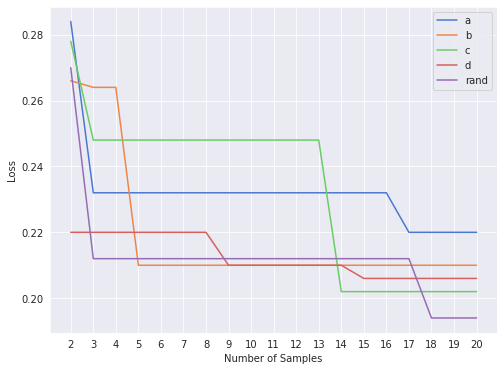

In [9]:
_, ax = plt.subplots(figsize=(8, 6))
# ax.set_title("Loss vs. Number of Samples")
ax.set_xlabel("Number of Samples")
ax.set_ylabel("Loss")
ax.set_xticks(range(2, 21))
plot_rolling_min(ax, rolling_mins, labels)
plt.show()